# Python 容器使用的 5 个技巧和 2 个误区

https://yq.aliyun.com/articles/719141?spm=a2c4e.11155472.0.0.5c217f8fqXNF7H

## 避免频繁扩充列表/创建新列表

- 更多的使用 yield 关键字，返回生成器对象

- 尽量使用生成器表达式替代列表推导表达式

    生成器表达式： (i for in range(100))
    
    列表推导表达式： [i for in range(100)]
    
- 尽量使用模块提供的懒惰对象：

    使用 re.finditer 替代 re.findall
    
    直接使用可迭代的文件对象： for line in fp，而不是 for line in fp.readlines()
    
## 在列表头部操作多的场景使用 deque 模块

## 使用集合/字典来判断成员是否存在

## 面向容器接口编程

In [3]:
def add_ellipsis_gen(comments, max_length=12):
    """如果可迭代评论里的内容超过 max_length，剩下的字符用省略号代替
    """
    for comment in comments:
        comment = comment.strip()
        if len(comment) > max_length:
            yield comment[:max_length] + '...'
        else:
            yield comment

comments = [
    "Implementation note",
    "Changed",
    "ABC for generator",
]
print("\n".join(add_ellipsis_gen(comments)))

Implementati...
Changed
ABC for gene...


## 使用元组改善分支代码

In [4]:
# 低级写法
import time
 

def from_now(ts):
    """接收一个过去的时间戳，返回距离当前时间的相对时间文字描述
    """
    now = time.time()
    seconds_delta = int(now - ts)
    if seconds_delta < 1:
        return "less than 1 second ago"
    elif seconds_delta < 60:
        return "{} seconds ago".format(seconds_delta)
    elif seconds_delta < 3600:
        return "{} minutes ago".format(seconds_delta // 60)
    elif seconds_delta < 3600 * 24:
        return "{} hours ago".format(seconds_delta // 3600)
    else:
        return "{} days ago".format(seconds_delta // (3600 * 24))


now = time.time()
print(from_now(now))
print(from_now(now - 24))
print(from_now(now - 600))
print(from_now(now - 7500))
print(from_now(now - 87500))

less than 1 second ago
24 seconds ago
10 minutes ago
2 hours ago
1 days ago


In [5]:
# 高级写法

import bisect


# BREAKPOINTS 必须是已经排好序的，不然无法进行二分查找
BREAKPOINTS = (1, 60, 3600, 3600 * 24)
TMPLS = (
    # unit, template
    (1, "less than 1 second ago"),
    (1, "{units} seconds ago"),
    (60, "{units} minutes ago"),
    (3600, "{units} hours ago"),
    (3600 * 24, "{units} days ago"),
)

def from_now(ts):
    """接收一个过去的时间戳，返回距离当前时间的相对时间文字描述
    """
    seconds_delta = int(time.time() - ts)
    unit, tmpl = TMPLS[bisect.bisect(BREAKPOINTS, seconds_delta)]
    return tmpl.format(units=seconds_delta // unit)

## 在更多地方使用动态解包

 Python 3.5 以后的版本，你可以直接用 ** 运算符来快速完成字典的合并操作

In [7]:
user = {**{"name": "piglei"}, **{"movies": ["Fight Club"]}}

##  最好不用“获取许可”，也无需“要求原谅”


In [8]:
# AF: Ask for Forgiveness
# 要做就做，如果抛出异常了，再处理异常
def counter_af(l):
    result = {}
    for key in l:
        try:
            result[key] += 1
        except KeyError:
            result[key] = 1
    return result


# AP: Ask for Permission
# 做之前，先问问能不能做，可以做再做
def counter_ap(l):
    result = {}
    for key in l:
        if key in result:
            result[key] += 1
        else:
            result[key] = 1
    return result

整个 Python 社区对第一种 Ask for Forgiveness 的异常捕获式编程风格有着明显的偏爱。这其中有很多原因，首先，在 Python 中抛出异常是一个很轻量的操作。其次，第一种做法在性能上也要优于第二种，因为它不用在每次循环的时候都做一次额外的成员检查。

如果你想统计次数的话，直接用 collections.defaultdict 就可以了：

In [9]:
from collections import defaultdict
 

def counter_by_collections(l):
    result = defaultdict(int)
    for key in l:
        result[key] += 1
    return result

这样的代码既不用“获取许可”，也无需“请求原谅”。整个代码的控制流变得更清晰自然了。所以，如果可能的话，请尽量想办法省略掉那些非核心的异常捕获逻辑。一些小提示：

- 操作字典成员时：使用 collections.defaultdict 类型

 或者使用 dict[key]=dict.setdefault(key,0)+1 内建函数

- 如果移除字典成员，不关心是否存在：

- 调用 pop 函数时设置默认值，比如 dict.pop(key,None)
- 在字典获取成员时指定默认值： dict.get(key, default_value)
- 对列表进行不存在的切片访问不会抛出 IndexError 异常： "foo"

## 使用 next() 函数,查找第一个符合的元素

next() 是一个非常实用的内建函数，它接收一个迭代器作为参数，然后返回该迭代器的下一个元素。使用它配合生成器表达式，可以高效的实现“从列表中查找第一个满足条件的成员”之类的需求。

In [10]:
numbers = [3, 7, 8, 2, 21]
# 获取并 **立即返回** 列表里的第一个偶数
print(next(i for i in numbers if i % 2 == 0))

8


## 使用有序字典来去重

字典和集合的结构特点保证了它们的成员不会重复，所以它们经常被用来去重。但是，使用它们俩去重后的结果会**丢失原有列表的顺序**。这是由底层数据结构“哈希表（Hash Table）”的特点决定的。

如果**既需要去重又必须保留顺序**怎么办？我们可以使用 `collections.OrderedDict` 模块

Hint: 在 Python 3.6 中，默认的字典类型修改了实现方式，已经变成有序的了。并且在 Python 3.7 中，该功能已经从 语言的实现细节 变成了为 可依赖的正式语言特性。

但是我觉得让整个 Python 社区习惯这一点还需要一些时间，毕竟目前“字典是无序的”还是被印在无数本 Python 书上。所以，我仍然建议在一切需要有序字典的地方使用 OrderedDict。

# 常见误区

## 当心那些已经枯竭的迭代器

我们提到了使用“懒惰”生成器的种种好处。但是，所有事物都有它的两面性。生成器的最大的缺点之一就是：它会枯竭。当你完整遍历过它们后，之后的重复遍历就不能拿到任何新内容了。



In [11]:
numbers = [1, 2, 3]
numbers = (i * 2 for i in numbers)

# 第一次循环会输出 2, 4, 6
for number in numbers:
    print(number)

# 这次循环什么都不会输出，因为迭代器已经枯竭了
for number in numbers:
    print(number)

2
4
6


而且不光是生成器表达式，Python 3 里的 map、filter 内建函数也都有一样的特点。忽视这个特点很容易导致代码中出现一些难以察觉的 Bug。

## 别在循环体内修改被迭代对象

In [16]:
def remove_even(numbers):
    """
    去掉列表里所有的偶数
    """
    for i, number in enumerate(numbers):
        if number % 2 == 0:
            # 有问题的代码
            del numbers[i]


numbers = [1, 2, 7, 4, 8, 11]
remove_even(numbers)
print(numbers)

[1, 7, 8, 11]


注意到结果里那个多出来的 “8” 了吗？当你在遍历一个列表的同时修改它，就会出现这样的事情。因为被迭代的对象 numbers 在循环过程中被修改了。遍历的下标在不断增长，而列表本身的长度同时又在不断缩减。这样就会导致列表里的一些成员其实根本就没有被遍历到。

所以对于这类操作，请使用一个新的空列表保存结果，或者利用 yield 返回一个生成器。而不是修改被迭代的列表或是字典对象本身。

# 判断pyhon版本

In [ ]:
import sys
PY2 = sys.version_info[0] == 2
PY3 = sys.version_info[0] == 3

# 线程锁装饰器 

In [1]:
def threadsafe_function(fcn):
    """decorator making sure that the decorated function is thread safe"""
    lock = threading.RLock()

    def new(*args, **kwargs):
        """Lock and call the decorated function

           Unless kwargs['threadsafe'] == False
        """
        threadsafe = kwargs.pop('threadsafe', True)
        if threadsafe:
            lock.acquire()
        try:
            ret = fcn(*args, **kwargs)
        except Exception as excpt:
            raise excpt
        finally:
            if threadsafe:
                lock.release()
        return ret
    return new


# 异常处理装饰器

使用轮子：pip install retry


```python
from retry import retry

@retry(tries=3, delay=1, )
def test():
    for i in range(-2, 5):
        print(1/i)
test()
```
自定义：

# 参数检查装饰器


In [1]:
import inspect


def check(fn):
    def wrapper(*args, **kwargs):
        sig = inspect.signature(fn)
        params = sig.parameters
        values = list(params.values())
        for i, p in enumerate(args):
            param = values[i]
            if param.annotation is not param.empty and not isinstance(
                    p, param.annotation):
                print(p, '!==', values[i].annotation)
        for k, v in kwargs.items():
            if params[k].annotation is not inspect._empty and not isinstance(
                    v, params[k].annotation):
                print(k, v, '!===', params[k].annotation)
        return fn(*args, **kwargs)

    return wrapper


@check
def add(x, y: int = 7) -> int:  #我们要求第二个参数必须是int类型,并且返回值类型也为int
    return x + y


print(add(2, 1))
print(add(20, y=10))
print(add(y=100, x=200))
print(add("Yin", "zhengjie"))  #我们在实际传参时故意不按照要求传参，发现会有相应的提示信息

3
30
300
zhengjie !== <class 'int'>
Yinzhengjie


In [1]:
# 异常捕获装饰器（亦可用于类方法）
import functools
import time
import traceback


def try_except_log(f=None, max_retries: int = 5, delay: (int, float) = 1, step: (int, float) = 0,
                   exceptions: (BaseException, tuple, list) = BaseException, sleep=time.sleep,
                   process=None, validate=None, callback=None, default=None):
    """
    函数执行出现异常时自动重试的简单装饰器
    :param f: function 执行的函数。
    :param max_retries: int 最多重试次数。
    :param delay: int/float 每次重试的延迟，单位秒。
    :param step: int/float 每次重试后延迟递增，单位秒。
    :param exceptions: BaseException/tuple/list 触发重试的异常类型，单个异常直接传入异常类型，多个异常以tuple或list传入。
    :param sleep: 实现延迟的方法，默认为time.sleep。
    在一些异步框架，如tornado中，使用time.sleep会导致阻塞，可以传入自定义的方法来实现延迟。
    自定义方法函数签名应与time.sleep相同，接收一个参数，为延迟执行的时间。
    :param process: 处理函数，函数签名应接收一个参数，每次出现异常时，会将异常对象传入。
    可用于记录异常日志，中断重试等。
    如处理函数正常执行，并返回True，则表示告知重试装饰器异常已经处理，重试装饰器终止重试，并且不会抛出任何异常。
    如处理函数正常执行，没有返回值或返回除True以外的结果，则继续重试。
    如处理函数抛出异常，则终止重试，并将处理函数的异常抛出。
    :param validate: 验证函数，用于验证执行结果，并确认是否继续重试。
    函数签名应接收一个参数，每次被装饰的函数完成且未抛出任何异常时，调用验证函数，将执行的结果传入。
    如验证函数正常执行，且返回False，则继续重试，即使被装饰的函数完成且未抛出任何异常。
    如验证函数正常执行，没有返回值或返回除False以外的结果，则终止重试，并将函数执行结果返回。
    如验证函数抛出异常，且异常属于被重试装饰器捕获的类型，则继续重试。
    如验证函数抛出异常，且异常不属于被重试装饰器捕获的类型，则将验证函数的异常抛出。
    :param callback: 回调函数，函数应接收一个参数，到达重试次数且异常无法处理时，会将异常对象传入。
    可用于记录异常日志，发送异常日志等。
    :param default: 发生异常时， process参数处理完返回True，返回：默认值 or 默认值生成函数
    :return: 被装饰函数的执行结果。
    """
    
    # 带参数的装饰器
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            # nonlocal delay, step, max_retries
            i = 0
            func_exc, exc_traceback = None, None
            while i < max_retries:
                try:
                    result = func(*args, **kwargs)
                    # 验证函数返回False时，表示告知装饰器验证不通过，继续重试
                    if callable(validate) and validate(result) is False:
                        continue
                    else:
                        # 正常结束
                        return result
                except exceptions as ex:
                    func_exc, exc_traceback = ex, traceback.format_exc()
                    # 处理函数返回True时，表示告知装饰器异常已经处理，终止重试
                    if callable(process):
                        try:
                            if process(ex) is True:
                                return default() if callable(default) else default
                        except Exception as e:
                            func_exc, exc_traceback = e, traceback.format_exc()
                            break
                # finally:
                i += 1
                sleep(delay + step * i)
            else:
                # 回调函数，处理自动无法处理的异常
                if callable(callback):
                    callback(func_exc, exc_traceback)
                return default() if callable(default) else default
            pass

        return wrapper

    if callable(f):
        return decorator(f)
    return decorator


@try_except_log(default=1)
def p():
    return 1/0


p()

1

# 使用goto语句

```sh
pip install goto-statement
```

具体的语法

In [ ]:
!conda install goto-statement

In [11]:
from goto import with_goto
 
@with_goto
def range(start, stop):
    i = start
    result = []
 
    label .begin
    if i == stop:
        goto .end
 
    result.append(i)
    i += 1
    goto .begin
 
    label .end
    return result

ModuleNotFoundError: No module named 'goto'

# enumerate 读取文件

如果要统计文件的行数，可以这样写：

count = len(open(filepath, 'r').readlines())

这种方法简单，但是可能比较慢，当文件比较大时甚至不能工作。

可以利用enumerate()：
```python
count = 0
for index, line in enumerate(open(filepath,'r'))： 
    count += 1
```

# 展开列表flat

In [1]:
a = [[[26, 25, 24], [23, 22, 21, 20, 19], [18, 17, 16]], [[15, 14, 13, 12, 11], [10, 9, 8], [7, 6, 5], [4, 3, 2, 1, 0], [[99, 98, 97], [96, 95, 94, 93], [92, 91, 90, 89, 88], [87, 86, 85, 84, 83]]], [[[82, 81, 80], [79, 78, 77, 76], [75, 74, 73], [72, 71, 70], [69, 68, 67]], [[66, 65, 64, 63], [62, 61, 60], [59, 58, 57, 56], [55, 54, 53, 52, 51]], [[50, 49, 48, 47, 46], [45, 44, 43, 42, 41], [40, 39, 38, 37, 36], [35, 34, 33, 32], [31, 30, 29, 28, 27]]]]

# result = []
# def flat_list(a: list):
#     for i in a:
#         if isinstance(i, list):
#             flat_list(i)
#         else:
#             result.append(i)


def flat_list(input_list :list):
    result = []
    for i in input_list:
        result.extend([i] if not isinstance(i, list) else flat_list(i))
    return result

print(flat_list(a))

[26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27]


# bytes数据

- bytes(iterable_of_ints) -> bytes
- bytes(string, encoding[, errors]) -> bytes
- bytes(bytes_or_buffer) -> immutable copy of bytes_or_buffer
- bytes(int) -> bytes object of size given by the parameter initialized with null bytes
- bytes() -> empty bytes object

In [7]:
a = bytes('中国', 'utf-8')
b = bytes('abc', 'ascii')
c = bytes(1)
d = bytes()
print("{}\n{}\n{}\n{}".format(a,b,c, d))

b'\xe4\xb8\xad\xe5\x9b\xbd'
b'abc'
b'\x00'
b''


In [19]:
list(b)

[97, 98, 99]

In [17]:
b.hex()

'616263'

In [21]:
bytes.fromhex(b.hex())

b'abc'

## 性能测试

In [2]:
a = '123abc我永远爱我的祖国'
print(a.encode() == bytes(a, 'utf-8'))

%timeit a.encode()

%timeit bytes(a, 'utf-8')

True
162 ns ± 14.7 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
280 ns ± 27.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


# bytearray
- bytearray(iterable_of_ints) -> bytearray
- bytearray(string, encoding[, errors]) -> bytearray
- bytearray(bytes_or_buffer) -> mutable copy of bytes_or_buffer
- bytearray(int) -> bytes array of size given by the parameter initialized with null bytes
- bytearray() -> empty bytes array

In [55]:
a = bytearray([1,2,3])
b = bytearray("你好", 'utf-8')
c = bytearray(bytes('abc', 'ascii'))
d = bytearray(1)
e = bytearray()
print("{}\n{}\n{}\n{}\n{}".format(a,b,c, d, e))

bytearray(b'\x01\x02\x03')
bytearray(b'\xe4\xbd\xa0\xe5\xa5\xbd')
bytearray(b'abc')
bytearray(b'\x00')
bytearray(b'')


In [57]:
list(c)

[97, 98, 99]

In [58]:
c.hex()

'616263'

In [59]:
bytearray.fromhex(c.hex())

bytearray(b'abc')

# binascii

In [61]:
import binascii

In [111]:
a = '123abc我永远爱我的祖国'
b = a.encode()

In [112]:
%timeit b.hex()

133 ns ± 3.42 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [113]:
%timeit binascii.hexlify(b)

228 ns ± 15 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [114]:
b_hex_str = b.hex()
b_hex_str

'313233616263e68891e6b0b8e8bf9ce788b1e68891e79a84e7a596e59bbd'

In [126]:
binascii.unhexlify(b_hex_str).decode()

'123abc我永远爱我的祖国'

In [117]:
binascii.hexlify(b)

b'313233616263e68891e6b0b8e8bf9ce788b1e68891e79a84e7a596e59bbd'

In [122]:
c = binascii.a2b_hex(b_hex_str)
c

b'123abc\xe6\x88\x91\xe6\xb0\xb8\xe8\xbf\x9c\xe7\x88\xb1\xe6\x88\x91\xe7\x9a\x84\xe7\xa5\x96\xe5\x9b\xbd'

# ascii & repr

In [50]:
ascii('123abc万')

"'123abc\\u4e07'"

In [51]:
repr("123abc万")

"'123abc万'"

# 版本

In [128]:
import sys

PY2 = sys.version_info[0] == 2
PY3 = sys.version_info[0] == 3

if PY2:
    import Queue as queue
    import SocketServer
else:
    import queue
    import socketserver as SocketServer

# 计算大小

In [12]:
import sys


def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj,
                                                     (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size


get_size(1), get_size(10000000000000000)

(28, 32)

# 图像二进制，bytes转换 (np.uint8)

1. 从numpy.ndarray (图片)到字节流

```python
x = img.tobytes()
```

2. 从二进制文件到图片(numpy.ndarray)

```python

```

In [2]:
cd C:\Users\13438\Desktop\

C:\Users\13438\Desktop


In [1]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from io import BytesIO
import numpy as np

## 图片 转 三维ndarray

### 方法一: np.frombuffer/np.frombuffer + cv2.imdecode

In [5]:
with open('Image.jpg', 'rb') as f:
    bin_str = f.read()
#     nparr = np.frombuffer(bin_str, np.uint8) # 字符串
    nparr = np.frombuffer(bin_str, np.uint8)
    img_np = cv2.imdecode(nparr, cv2.IMREAD_COLOR) # cv2.CV_LOAD_IMAGE_COLOR  in CV < 3.1
    
    print(type(bin_str))
    print(nparr.shape)
    print(img_np.shape)

<class 'bytes'>
(84649,)
(576, 704, 3)


### 方法二: cv2.imread

In [45]:
img_np = cv2.imread('Image.jpg')

### 方法三 ：plt.imread

In [55]:
with open('Image.jpg', 'rb') as f:
    img_data = plt.imread(BytesIO(f.read()),"jpg")
    print(type(img_data))
    print(img_data.shape)

<class 'numpy.ndarray'>
(576, 704, 3)


### 方法 四：PLT.Image

略

## 三维ndarray图 转 一维ndarray

encode 成一维，然后 tobytes()

In [41]:
# 构造图片
# img_data = np.linspace(0,255,100*100*3).reshape(100,100,-1).astype(np.uint8)

# 上面的图片转 ndarray
img_data = img_np
ret, buf = cv2.imencode(".jpg", img_data)
if ret:
    print(img_data.shape, buf.shape)

(576, 704, 3) (84970, 1)


## 一维转 bytes
接着上一步得到的一维数组

### 方法一：

需要转化

In [37]:
if ret:
    img_bin1 = Image.fromarray(np.uint8(buf)).tobytes()
    # 保存图片
    with open('pic.jpg', 'wb') as f:
        f.write(img_bin1)

### 方法二：

直接转 bytes()

In [38]:
img_bin2 = buf.tobytes()
# 保存。。。
with open('pic2.jpg', 'wb') as f:
    f.write(img_bin2)

### 两种方法结果对比

方法二省去了中间转换步骤，效率提高了200~300倍

In [46]:
img_bin1 == img_bin2

True

In [48]:
%timeit img_bin1 = Image.fromarray(np.uint8(buf)).tobytes()

612 µs ± 180 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [49]:
%timeit a = buf.tobytes()

2.34 µs ± 39.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## 三维转bytes

先转一维再保存为bytes

In [2]:
cd assets/

D:\OneDrive - business\jupyter notebook\Modules-Learn\assets


In [34]:
import cv2
from PIL import Image
from io import BytesIO

(256, 256, 3) (33893, 1)


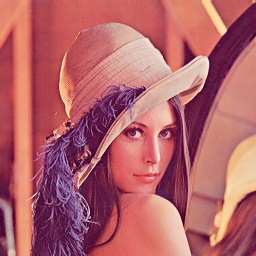

In [96]:
# 读一张数组到 三维数组
img_data = cv2.imread('lena.jpg')
# 转为一维
ret, buf = cv2.imencode(".jpg", img_data)
assert ret
print(img_data.shape, buf.shape)
# 展示
img = Image.open(BytesIO(buf.tobytes()))
img

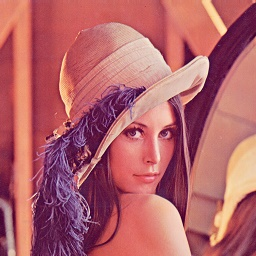

In [97]:
img = Image.fromarray(cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB))
img

# 懒加载

In [16]:
 class LazyImport:
    def __init__(self, module_name):
        self.module_name = module_name
        self.module = None
        
    def __getattr__(self, name):
        if self.module is None:
            self.module = __import__(self.module_name)
        return getattr(self.module, name)
    
string = LazyImport("string")
print (string.digits)

0123456789


# 创建文件夹

In [1]:
import errno


def mkdir_p_ex(path):
    try:
        if os.path.exists(path) and os.path.isdir(path):
            return True, None

        os.makedirs(path)
        return True, None
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            return True, None
        else:
            return False, str(exc)
    except Exception as e:
        return False, str(e)
